In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xcdat

In [161]:
def create_octahedral_grid(n):
    """
    Creates an octahedral grid with resolution parameter n.
    Returns longitude and latitude coordinates of grid points and grid cell edges.
    
    Parameters:
    n : integer
        Resolution parameter. ECMWF uses values like O1280 (n=1280)
        For visualization, use smaller values like 16, 32, etc.
    """
    # Total number of latitude bands (excluding poles)
    n_lat = n
    
    # Generate latitude bands
    # Equally spaced in sine of latitude from South to North pole
    #NO: Lats are zeros of the Legendre polynomial
    #sin_lat = np.linspace(-1, 1, n_lat + 2)
    #lats = np.arcsin(sin_lat) * 180 / np.pi
    ds_gaussian = xcdat.regridder.grid.create_gaussian_grid(n)
    lats = np.append([-90.],ds_gaussian.lat_bnds.values[::-1,0])
    
    # For each latitude, generate appropriate number of points
    grid_points = []
    
    # South pole
    grid_points.append((0, -90))
    
    # For each non-pole latitude
    for i in range(1, n_lat):
        # Number of points at this latitude (increases toward equator)
        if i <= n_lat // 2:
            # Southern hemisphere
            n_lon = 4 * i
        else:
            # Northern hemisphere
            n_lon = 4 * (n_lat  - i)
        
        # Generate equally spaced longitudes
        lons = np.linspace(0, 360, n_lon, endpoint=False)
        
        # Add all points at this latitude
        for lon in lons:
            grid_points.append((lon, lats[i]))
    
    # North pole
    grid_points.append((0, 90))
    
    # Generate grid cell edges
    edges = []
    
    # Keep track of starting index for each latitude band
    lat_start_idx = [0]  # South pole is at index 0
    count = 1
    
    for i in range(1, n_lat):
        if i <= n_lat // 2:
            n_lon = 4 * i
        else:
            n_lon = 4 * (n_lat - i )

        #print((i,n_lon,lats[i]))
        lat_start_idx.append(count)
        count += n_lon
    
    lat_start_idx.append(count)  # North pole
    
    # Connect South pole to first latitude band
    south_pole_idx = 0
    first_lat_start = lat_start_idx[1]
    first_lat_end = lat_start_idx[2]
    
    for i in range(first_lat_start, first_lat_end):
        edges.append((south_pole_idx, i))
    
    # Connect latitude bands and create cells
    for lat_idx in range(1, n_lat):
        current_lat_start = lat_start_idx[lat_idx]
        current_lat_end = lat_start_idx[lat_idx + 1]
        next_lat_start = lat_start_idx[lat_idx + 1]
        next_lat_end = lat_start_idx[lat_idx + 1]
        
        n_current = current_lat_end - current_lat_start
        n_next = next_lat_end - next_lat_start
        
        # Connect points within the same latitude
        for i in range(n_current):
            edges.append((
                current_lat_start + i,
                current_lat_start + (i + 1) % n_current
            ))

    # Connect points between latitudes
    Npoints = len(grid_points)
    
    # Southern hemisphere
    # Start from a meridian
    for nmeridian in [1,2,3,4]:
        istart = 0
        for n in range(1, n_lat//2+1):
            #print(f" Starting {n}")
            istart_prev = istart
            istart = istart + 4*(n-1) + (nmeridian) #starting index shifted up by number of cells in previous latitude circle
            if n > 1:
                istart = istart - 1    

            #print(f" Starting {nmeridian},{n},{4*(n-1) + (nmeridian)}: {istart_prev}, {istart}")

            edges.append((istart_prev,istart))
    
            #eastgoing
            m = n
            i = istart
            while m <= n_lat//2 - 1:
                j = i + 4*m + nmeridianyin_yang_eq.pdf
                edges.append((i,j))
                #print([m,i,j])
                i = j
                m += 1
                
            # #westgoing
            m = n
            i = istart
            while m <= n_lat//2 - 1 :
                if nmeridian == 1:
                    if i == istart: #Problem point
                        j = i + 4*m + nmeridian + 4*(m+1) - 2
                    else:
                        j = i + 4*(m+1) + nmeridian - 2    
                    #print([m,i,j])
                else:
                    j = i + 4*m + nmeridian - 2
                edges.append((i,j))
                i = j
                m += 1
            
    # Northern hemisphere
    for nmeridian in [1,2,3,4]:
        istart = Npoints -1 #- 6 + nmeridian
        #for n in range(n_lat+1, n_lat//2, -1):
        for n in range(n_lat-1, (n_lat//2)-1, -1):
                
            istart_prev = istart
            istart = istart - 4*(n_lat - n ) + (nmeridian)

            if n < n_lat + 1:
                istart = istart - 1
            
            #print(f" Starting {nmeridian},{n}, {- 4*(n_lat - n ) + (nmeridian)}: {istart_prev}, {istart}")
    
            #meridian
            edges.append((istart_prev,istart))
            
            #eastgoing
            m = n
            i = istart
            while m >= n_lat//2 + 1:
                j = i - 4*(n_lat - m + 1)  + nmeridian
                edges.append((i,j))
                #if nmeridian == 1:
                #    print([m,i,j])
                i = j
                m -= 1
                
            # # #Westgoing
            m = n
            i = istart
            while m >= n_lat//2 + 1:
                if nmeridian == 1:
                    if i == istart: #Problem point
                        j = i - 1 
                    else:
                        j = i - 4*(n_lat - m + 1)  + nmeridian + 2
                    #print(f"{m},{i},{j}")
                else:
                    j = i - 4*(n_lat - m + 1)  + nmeridian - 2
                edges.append((i,j))
                i = j
                m -= 1

        
        
    # Connect last latitude band to North pole
    north_pole_idx = lat_start_idx[-1]
    last_lat_start = lat_start_idx[-2]
    last_lat_end = lat_start_idx[-1]
    
    for i in range(last_lat_start, last_lat_end):
        edges.append((i, north_pole_idx))
    
    return np.array(grid_points), edges

In [169]:

def plot_octahedral_grid(n, projection='ortho', central_lon=0, central_lat=30, figsize=(10, 10)):
    """
    Plot the octahedral grid with given resolution and projection
    
    Parameters:
    n : integer
        Resolution parameter
    projection : string
        Map projection ('ortho', 'moll', 'robin', 'PlateCarree')
    central_lon, central_lat : float
        Center coordinates for orthographic projection
    """
    # Create the grid
    points, edges = create_octahedral_grid(n)
    
    # Setup the projection
    if projection == 'ortho':
        proj = ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat)
    elif projection == 'moll':
        proj = ccrs.Mollweide(central_longitude=central_lon)
    elif projection == 'robin':
        proj = ccrs.Robinson(central_longitude=central_lon)
    elif projection == 'PlateCarree':
        proj = ccrs.PlateCarree()
    else:
        raise ValueError("Unknown projection")
    
    # Create figure and axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    # # Add coastlines for reference
    # ax.coastlines(linewidth=0.5, color='gray')

    # #Draw points and optional indices
    # ax.plot(points[:,0],points[:,1],'.',color='k',
    #             transform=ccrs.Geodetic())
    # for i, point in enumerate(points):        
    #     ax.annotate(str(i),point,transform=ccrs.Geodetic()) 
    
    # Draw grid lines
    for edge in edges:
        p1_idx, p2_idx = edge
        p1_lon, p1_lat = points[p1_idx]
        p2_lon, p2_lat = points[p2_idx]
        
        # Handle longitude wrapping
        if abs(p1_lon - p2_lon) > 180:
            # Adjust longitude to avoid crossing the dateline
            if p1_lon > p2_lon:
                p2_lon += 360
            else:
                p1_lon += 360
        
        # Draw the line
        ax.plot([p1_lon, p2_lon], [p1_lat, p2_lat],
                color='black', linewidth=0.5,
                transform=ccrs.Geodetic())
        

    
    # Add gridlines
    #ax.gridlines(linewidth=0.3, color='#2980b9', alpha=0.5)
    
    ax.set_title(f'Octahedral Grid', fontsize=14) # (O{n})')
    ax.set_global()
    plt.tight_layout()
    
    return fig, ax

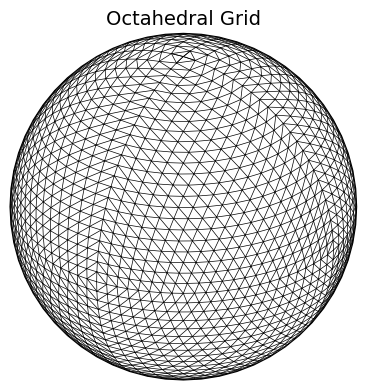

In [172]:
fig1, ax1 = plot_octahedral_grid(n=48, projection='ortho',central_lat=30,central_lon=30,figsize=(4,4))
plt.savefig('octahedral-grid.pdf', bbox_inches='tight')